# Faire un métamodèle de krigeage


## Références

http://openturns.github.io/openturns/master/theory/meta_modeling/kriging.html

http://openturns.github.io/openturns/master/examples/meta_modeling/kriging.html

## Référence

- François Bachoc. Introduction to Gaussian-process based Kriging models for metamodeling and validation of computer codes. Seminar of the LRC MANON, INSTN Saclay, March 2014. [LRC_Manon_2014.pdf](https://www.math.univ-toulouse.fr/~fbachoc/LRC_Manon_2014.pdf)

- C. E. Rasmussen & C. K. I. Williams, Gaussian Processes for Machine Learning, the MIT Press, 2006,
ISBN 026218253X. 2006 Massachusetts Institute of Technology. www.GaussianProcess.org/gpml

- François Bachoc. Parametric estimation of covariance function in Gaussian-process based Kriging models. Application to uncertainty quantification for computer experiments. Thèse de l'université Paris-Diderot, 2013. https://tel.archives-ouvertes.fr/tel-00881002/

- Loïc Le Gratiet. Multi-fidelity Gaussian process regression for computer experiments. Thèse de l'université Paris-Diderot, 2013. https://tel.archives-ouvertes.fr/tel-00866770

- Normalization of the input sample in KrigingAlgorithm in OT1.16. [openturns.discourse.group](https://openturns.discourse.group/t/normalization-of-the-input-sample-in-krigingalgorithm-in-ot1-16/101)


## Le krigeage dans OpenTURNS

### Le modèle de déviation de la poutre encastrée

On considère le modèle de [poutre encastrée](https://github.com/mbaudin47/otsupgalilee-eleve/blob/master/0-Deroulement/Poutre-encastree.md). On fait l'hypothèse que les variables aléatoires E, F, L et I sont liées par une copule gaussienne dont la matrice de corrélation est :
$$
R = 
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & -0.2 \\
0 & 0 & -0.2 & 1
\end{pmatrix}
$$

En d'autres termes, on considère que les variables $L$ et $I$ sont corrélées négativement : lorsque la longueur $L$ augmente, le moment d'inertie $I$ diminue. 

On crée un métamodèle de krigeage fondé sur un modèle exponentiel carré. Pour estimer le métamodèle, nous allons utiliser un plan d'expériences de taille 20. 

### Définition du modèle

In [1]:
import openturns as ot
import openturns.experimental as otexp
import openturns.viewer as otv

In [2]:
class Plongeoir:
    """
    Définit le modèle physique et probabiliste d'un plongeoir.

    Cette classe encapsule la définition des variables aléatoires d'entrée
    (module de Young, charge, longueur, moment d'inertie) et la fonction
    modèle calculant la déviation verticale de la poutre.

    Examples
    --------
    >>> plongeoir = Plongeoir()
    >>> X = plongeoir.getProbabilisticModel()
    >>> g = plongeoir.getPhysicalModel()
    """
    def __init__(self, avecDependance=False, correlationLI=-0.2):
        """
        Initialise les distributions et le modèle symbolique.

        Parameters
        ----------
        avecDependance : bool
            Si True, alors utilise une structure de dépendance avec une 
            copule gaussienne et un coefficient de corrélation déterminé 
            par correlationLI.
        correlationLI : float
            Le coefficient de corrélation entre L et I
        """
        distributionE = ot.Beta(0.9, 3.5, 65.0e9, 75.0e9)
        distributionE.setDescription(["E (Pa)"])
        parametersF = ot.LogNormalMuSigma(
            300.0, 30.0, 0.0
        )  # Paramétrage par les moments
        distributionF = ot.ParametrizedDistribution(parametersF)
        distributionF.setDescription(["F (N)"])
        distributionL = ot.Uniform(2.50, 2.60)  # En mètres
        distributionL.setDescription(["L (m)"])
        distributionI = ot.Beta(2.5, 4.0, 1.3e-7, 1.7e-7)  # En m⁴
        distributionI.setDescription(["I (m⁴)"])

        if avecDependance:
            inputDimension = 4
            R = ot.CorrelationMatrix(inputDimension)
            R[2, 3] = correlationLI
            copula = ot.NormalCopula(ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(R))

            self.distribution = ot.JointDistribution(
                [distributionE, distributionF, distributionL, distributionI], copula
            )
        else:
            self.distribution = ot.JointDistribution(
                [distributionE, distributionF, distributionL, distributionI],
            )

        self.model = ot.SymbolicFunction(["E", "F", "L", "I"], ["F * L ^ 3 / (3 * E * I)"])
        self.model.setInputDescription(self.distribution.getDescription())
        self.model.setOutputDescription(["Y (m)"])

    def getProbabilisticModel(self):
        """
        Retourne la distribution conjointe des variables d'entrée.

        Returns
        -------
        distribution : ot.JointDistribution
            La distribution conjointe des variables aléatoires d'entrée.
        """
        return self.distribution

    def getPhysicalModel(self):
        """
        Retourne le modèle physique sous forme de fonction symbolique.

        Returns
        -------
        model : ot.SymbolicFunction
            La fonction calculant la déviation verticale.
        """
        return self.model

In [3]:
plongeoir = Plongeoir(avecDependance=True)
inputDistribution = plongeoir.getProbabilisticModel()
model = plongeoir.getPhysicalModel()
inputDistribution

Index,Variable,Distribution
0,E (Pa),"Beta(alpha = 0.9, beta = 3.5, a = 6.5e+10, b = 7.5e+10)"
1,F (N),"ParametrizedDistribution(parameters = LogNormalMuSigma(mu = 300, sigma = 30, gamma = 0))"
2,L (m),"Uniform(a = 2.5, b = 2.6)"
3,I (m⁴),"Beta(alpha = 2.5, beta = 4, a = 1.3e-07, b = 1.7e-07)"


### Définition d'un plan d'expériences

Nous considérons un plan d'expériences de type Monte-Carlo simple. Pour cela, on génère un échantillon des entrées grâce à la méthode `getSample`. Puis nous évaluons la sortie en appelant la fonction `model`.

In [4]:
sampleSizeTrain = 20
xTrain = inputDistribution.getSample(sampleSizeTrain)
yTrain = model(xTrain)

Observons la distribution des déviations verticales Y sur la base d'apprentissage. On observe que les déviations plus grandes sont moins fréquentes. 

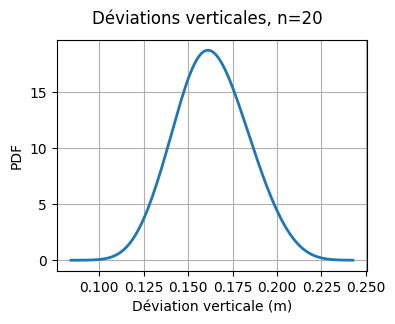

In [5]:
graph = ot.KernelSmoothing().build(yTrain).drawPDF()
graph.setXTitle("Déviation verticale (m)")
graph.setTitle(f"Déviations verticales, n={yTrain.getSize()}")
graph.setLegends([""])
_ = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

### Création du métamodèle

L'élaboration du métamodèle s'appuie sur la classe `GaussianProcessFitter`, paramétrée par une tendance constante (`ConstantBasisFactory`), un modèle de covariance exponentielle carrée et la base d'apprentissage.

L'estimation des hyperparamètres par maximum de vraisemblance s'avère délicate lorsque les variables d'entrée présentent des ordres de grandeur très hétérogènes. Dans le cas de la poutre encastrée, ces disparités sont marquées :

* *E* : ordre de grandeur de $10^9$ ;
* *F* : ordre de grandeur de $10^2$ ;
* *L* : ordre de grandeur de $10^0$ ;
* *I* : ordre de grandeur de $10^{-7}$.

Pour contourner cette difficulté d'optimisation, deux approches existent : l'ajustement fin de l'algorithme (bornes et point initial) ou la standardisation des variables sur un intervalle de référence (généralement entre 0 et 1). Depuis la version 1.26, OpenTURNS intègre automatiquement une transformation min-max au sein de la classe `GaussianProcessFitter` (requêtes [3044](https://github.com/openturns/openturns/pull/3044) et [330154](https://github.com/openturns/openturns/pull/3015)). La mise à l'échelle est donc désormais systématique et transparente pour l'utilisateur de la bibliothèque.

Bien que cette automatisation rende le réglage manuel de l'optimiseur facultatif dans les versions récentes, la cellule suivante l'implémente à des fins purement pédagogiques. La méthode consiste à guider l'algorithme en définissant ses bornes de recherche à partir de l'étendue de l'échantillon (la différence entre son maximum et son minimum). Concrètement, la borne inférieure est fixée à un dixième de cette étendue, et la borne supérieure à cinq fois celle-ci. Parallèlement, les longueurs de corrélation sont initialisées à la valeur maximale observée pour chaque composante. Ces paramètres heuristiques ne garantissent pas une estimation systématiquement parfaite et peuvent nécessiter une adaptation selon le cas d'étude.


In [6]:
dimension = inputDistribution.getDimension()
basis = ot.ConstantBasisFactory(dimension).build()
covarianceModel = ot.SquaredExponential([1.0] * dimension, [1.0])
covarianceModel.setScale(xTrain.getMax())
fitter = otexp.GaussianProcessFitter(xTrain, yTrain, covarianceModel, basis)
xRange = xTrain.getMax() - xTrain.getMin()  # Trick B, v2
scaleMaxFactor = 5.0  # Doit être > 1
scaleMinFactor = 0.1  # Doit être < 1
maximumScaleBounds = scaleMaxFactor * xRange
minimumScaleBounds = scaleMinFactor * xRange
scaleOptimizationBounds = ot.Interval(minimumScaleBounds, maximumScaleBounds)
fitter.setOptimizationBounds(scaleOptimizationBounds)
scaleOptimizationBounds

class=Interval name=Unnamed dimension=4 lower bound=class=Point name=Unnamed dimension=4 values=[6.98437e+08,10.7047,0.0081952,2.48453e-09] upper bound=class=Point name=Unnamed dimension=4 values=[3.49219e+10,535.236,0.40976,1.24227e-07] finite lower bound=[1,1,1,1] finite upper bound=[1,1,1,1]

In [7]:
fitter.run()
gpr = otexp.GaussianProcessRegression(fitter.getResult())
gpr.run()

In [8]:
gprResult = gpr.getResult()
krigeageMetaModel = gprResult.getMetaModel()

La méthode `run` a évalué les paramètres du modèle par la méthode du maximum de vraisemblance. 

On peut alors afficher la tendance constante du modèle.

In [9]:
gprResult.getTrendCoefficients()

class=Point name=Unnamed dimension=1 values=[0.218585]

On peut également afficher les paramètres du modèle de covariance, estimés par la méthode du maximum de vraisemblance.

In [10]:
covarianceModel = gprResult.getCovarianceModel()
amplitude = covarianceModel.getAmplitude()
scale = covarianceModel.getScale()
print(f"amplitude={amplitude[0]}")
print(f"scale={scale}")
print(f"Bounds = ")
print(f"{scaleOptimizationBounds}")


amplitude=0.10271880578686185
scale=[3.49219e+10,350.167,0.40976,1.05888e-07]
Bounds = 
[6.98437e+08, 3.49219e+10]
[10.7047, 535.236]
[0.0081952, 0.40976]
[2.48453e-09, 1.24227e-07]


On peut se demander si les paramètres sont proches des bornes de l'intervalle de recherche. Dans ce cas, cela signifie que l'algorithme d'optimisation est limité par les bornes, ce qui peut être instructif.

In [11]:
inputDimension = inputDistribution.getDimension()
inputDescription = inputDistribution.getDescription()
relativeTolerance = 1.0e-1
for i in range(inputDimension):
    if abs(minimumScaleBounds[i] - scale[i]) <= relativeTolerance * abs(scale[i]):
        print(
            f"Attention! Le paramètre d'échelle (#{i}) {inputDescription[i]} est {scale[i]}, "
            f"ce qui est proche de la borne inférieure {minimumScaleBounds[i]}"
        )
    if abs(maximumScaleBounds[i] - scale[i]) <= relativeTolerance * abs(scale[i]):
        print(
            f"Attention! Le paramètre d'échelle (#{i}) {inputDescription[i]} est {scale[i]}, "
            f"ce qui est proche de la borne supérieure {maximumScaleBounds[i]}"
        )

Attention! Le paramètre d'échelle (#0) E (Pa) est 34921867208.21132, ce qui est proche de la borne supérieure 34921867208.21133
Attention! Le paramètre d'échelle (#2) L (m) est 0.4097598262418111, ce qui est proche de la borne supérieure 0.4097598262418112


On observe que les longueurs de corrélation optimisées $\theta_F^\star$ et $\theta_I^\star$ sont strictement à l'intérieur du domaine. En revanche, la longueur de corrélation optimale pour les paramètres $E$ et $L$ sont proches de la borne maximale utilisée par l'algorithme d'optimisation. Cette longueur de corrélation optimale est supérieure à l'étendue du domaine de définition de la variable $L$, égale à $2.6 - 2.5 = 0.1$.

Une grande longueur de corrélation signifie que deux points $\boldsymbol{x}_1=(E, F, L_1, I)^T$ et $\boldsymbol{x}_2=(E, F, L_2, I)^T$ tels que $L_1$ et $L_2$ sont très éloignés sont associées à des valeurs de $Y = g(\boldsymbol{x})$ très proches. Ce résultat est cohérent avec le fait que la fonction $g$ est peu sensible à la variable $L$, comme on peut le voir en réalisant l'analyse de sensibilité globale du modèle (son indice de Sobol' total est proche de zéro). En d'autres termes, la fonction $g$ est presque constante lorsque $L$ change (et que les autres paramètres sont maintenus constants). Le constat est le même pour la variable $E$.

On peut se demander si augmenter la largeur de l'intervalle de recherche peut améliorer la qualité des prédictions. Dans le cas de la poutre encastrée, cela n'est pas nécessairement le cas, car le modèle est peu sensible aux paramètres $E$ et $L$.


On souhaite ensuite valider le métamodèle de krigeage. Pour cela, on génère un échantillon de validation de taille 100 et on évalue la sortie du modèle sur cet échantillon.

In [12]:
sampleSizeTest = 100
xTest = inputDistribution.getSample(sampleSizeTest)
yTest = model(xTest)

Sur l'échantillon de validation, on évalue les sorties du métamodèle.

In [13]:
yTestMetaModel = krigeageMetaModel(xTest)

La classe `MetaModelValidation` facilite le travail de validation d'un métamodèle. Pour la construire, on lui donne les entrées de la base de validation, les sorties correspondantes et le métamodèle.

In [14]:
krigingMetaModelPredictions = krigeageMetaModel(xTest)
validation = ot.MetaModelValidation(yTest, krigingMetaModelPredictions)

La méthode `computeR2Score` permet d'estimer le coefficient $Q^2$.

In [18]:
validation.computeR2Score()[0]

0.9997203842563847

Puisque le $Q^2$ est supérieur à 0.95, on peut dire que c'est un très bon métamodèle.

Il est intéressant de dessiner l'histogramme des résidus : on peut le faire avec la classe `HistogramFactory` appliquée à l'échantillon des résidus `r`. 

On observe que les résidus négatifs sont presque aussi fréquents que les résidus positifs : c'est plutôt un signe positif pour la qualité du métamodèle. Dans notre cas, la déviation verticale est plutôt petite, de l'ordre de $10^{-5}$. Cela implique qu'il n'est pas si simple de voir si, en valeur absolue, les résidus sont plutôt petits, ou non : le graphique que nous dessinerons par la suite est plus fiable de ce point de vue.

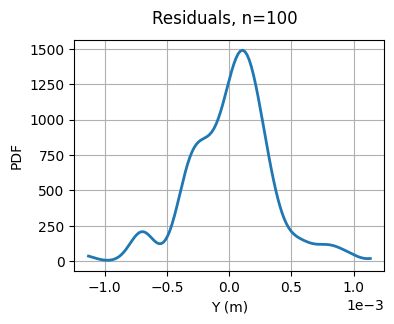

In [16]:
residualsSample = validation.getResidualSample()
graph = ot.KernelSmoothing().build(residualsSample).drawPDF()
graph.setTitle(f"Residuals, n={residualsSample.getSize()}")
graph.setLegends([""])
_ = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

La méthode `drawValidation` permet de comparer les données observées et les prédictions du métamodèle. 

On observe que les croix rouges sont à proximité de la première bissectrice : cela montre que le métamodèle est plutôt de bonne qualité.

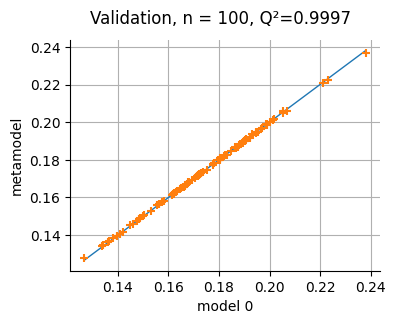

In [17]:
graph = validation.drawValidation()
graph.setTitle(f"Validation, n = {sampleSizeTest}, Q²={Q2:.4f}")
_ = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

## Annexe : coefficient de prédictivité

Le facteur de prédictivité Q² est un coefficient qui mesure la qualité d'un métamodèle. 
* C'est un nombre inférieur ou égal à 1.
* Si Q² est proche de 1, alors le métamodèle est excellent.
* Si Q² est proche de 0, alors le métamodèle est une mauvaise approximation de la fonction.
* Si Q² est inférieur à 0, alors, en moyenne quadratique, la moyenne empirique $\overline{y}$ est une meilleure prévision que celle produite par le métamodèle.


En pratique, un Q² supérieur à 0.95 est qualifié de satisfaisant. 

On suppose que l'on dispose de $n$ entrées de validation $\boldsymbol{x}_i$ ainsi que des observations $y_i$ correspondantes. 
On note $\widetilde{g}$ le métamodèle. 
Soit $\overline{y}$ la moyenne des observations de validation :
$$
\overline{y} = \frac{1}{n} \sum_{i=1}^{n} y^{(i)}.
$$
Le coefficient $Q^2$ est défini par l'équation :
$$
Q^2 = 1 - \frac{\sum_{i=1}^{n} \left(y^{(i)} - \widetilde{g}\left(\boldsymbol{x}^{(i)}\right)\right)^2}{\sum_{i=1}^{n} \left(y^{(i)} - \overline{y}\right)^2}.
$$

## Exercices

### Exercice 1 : sensibilité à la taille de l'échantillon d'apprentissage

On s'interroge sur l'évolution de la qualité du métamodèle lorsque le nombre de points dans le plan d'expériences augmente. 

**Questions.**
* Modifier le plan d'expériences utilisé pour apprendre le métamodèle : utiliser `sampleSizeTrain = 100`. 
* Mettre à jour le métamodèle de krigeage. 
* Comment évolue le coefficient de prédictivité ?
* Pourquoi ?



### Exercice 2 : utilisation d'une tendance

Il y a trois classes qui permettent de créer des modèles de tendance.
* `ConstantBasisFactory` : tendance constante ;
* `LinearBasisFactory` : tendance linéaire ;
* `QuadraticBasisFactory` : tendance quadratique.

**Questions.**

* Mettre à jour la tendance du modèle et utiliser une tendance linéaire. 
* Quelle est la tendance estimée par la méthode du maximum de vraisemblance ?
* Quel est l'impact sur la qualité du métamodèle ?



### Exercice 3 : nombre d'observations et nombre de paramètres

On souhaite vérifier que le nombre d'observations est suffisant pour estimer correctement les paramètres. 

**Questions.**

* Calculer le nombre de paramètres estimés dans le krigeage. Pour cela, faire la somme du nombre de paramètres de la tendance et du noyau de covariance.
* Calculer le nombre d'observations dans le plan d'expériences. 
* Calculer le ratio entre le nombre d'observations et le nombre de paramètres. 
* La taille du plan d'expériences est-elle suffisante pour estimer les paramètres ?



### Exercice 4 : distribution des résidus

On souhaite valider la qualité du métamodèle. Nous avons vu comment récupérer les résidus avec la classe `getResidualSample` et tracer une approximation de la densité de probabilité de ces résidus avec la classe `KernelSmoothing`.

**Questions.**
* Utiliser la méthode `getResidualDistribution` pour obtenir la distribution des résidus.
* Utiliser la méthode `drawPDF` pour dessiner la distribution des résidus.
* Que conclure ?

### Exercice 5 : Utiliser un algorithme d'optimisation global

Lorsque l'on estime les hyperparamètres d'un modèle de krigeage, une des difficultés consiste à obtenir des bons résultats avec l'algorithme d'optimisation. En effet, si on utilise un algorithme d'optimisation local comme l'algorithme BFGS, celui-ci peut converger vers un minimum local qui n'est pas satisfaisant. Le problème est généré par le comportement de l'algorithme, qui converge souvent vers l'optimum local le plus proche du point de départ de l'algorithme. Une méthode pour pallier cela consiste à démarrer l'algorithme avec un nouveau point de départ. On peut généraliser cela en considérant un ensemble fini de points de départ, par exemple quelques dizaines. Cette stratégie se nomme « _Multi-start » dans la littérature. Cela n'implique pas des nouvelles évaluations du modèle, mais nécessite de répéter l'estimation des hyperparamètres par la méthode du maximum de vraisemblance. Cette méthode peut permettre d'obtenir des bons résultats (voir (Basak, Petit, Bect & Vazquez, 2021)). L'objectif de cette question est de mettre cette méthode en oeuvre.

##### Références

- Subhasish Basak, Sébastien Petit, Julien Bect, Emmanuel Vazquez. Numerical issues in maximum likelihood parameter estimation for Gaussian process interpolation. 7th International Conference on machine Learning, Optimization and Data science (LOD 2021), Oct 2021, Grasmere, United Kingdom. 10.1007/978-3-030-95470-3_9. hal-03119528v2


**Questions.**

* Générer les points de départ de l'algorithme : utiliser la méthode `getSample` sur l'objet `scaleDistribution` pour extraire un échantillon de taille 25 (défini par la variable `sampleSizeMultiStart`).
* Créer l'algorithme d'optimisation global : instancier la classe `MultiStart` en lui passant deux arguments, à savoir l'algorithme d'optimisation local (`solver`) et les points de départ générés à l'étape précédente (`startingPoints`).
* Configurer la méthode d'estimation : utiliser la méthode `setOptimizationAlgorithm` sur l'objet `fitter` pour lui assigner le nouvel algorithme global (`multiStartSolver`).
* Afficher le résultat : utiliser la méthode `getCovarianceModel` sur l'objet `gprResult` afin de récupérer et d'afficher le modèle de covariance avec ses hyperparamètres optimisés.
* Pourquoi l'utilisation de plusieurs points de départ est-elle particulièrement recommandée lorsque la dimension du problème augmente ou que la fonction de vraisemblance est irrégulière ?


**Squelette de code.**

Pour réaliser cet exercice, on pourra s'appuyer sur la fonction suivante.

```python
def createUniformJointDistributionFromInterval(interval):
    """
    Crée une loi multidimensionnelle uniforme à partir d'un intervalle.

    Chaque composante marginale est une loi uniforme indépendante.

    Voir https://github.com/openturns/openturns/issues/3112.

    Parameters
    ----------
    interval : ot.Interval
        L'intervalle. La borne inférieure de chaque composante doit être
        inférieure ou égale à la borne supérieure.

    Returns
    -------
    distribution : ot.JointDistribution
        La loi jointe.
    """
    lowerBound = interval.getLowerBound()
    upperBound = interval.getUpperBound()
    dimension = interval.getDimension()
    marginalDistributions = []
    for i in range(dimension):
        uniformMarginal = ot.Uniform(lowerBound[i], upperBound[i])
        marginalDistributions.append(uniformMarginal)
    jointDistribution = ot.JointDistribution(marginalDistributions)
    return jointDistribution
```

le code suivant, où l'on remplacera les sections `TODO` par du code valide.

```python
solver = fitter.getOptimizationAlgorithm()
sampleSizeMultiStart = 25
scaleDistribution = createUniformJointDistributionFromInterval(scaleOptimizationBounds)
# Génération des points de départ
startingPoints = scaleDistribution.TODO(sampleSizeMultiStart)
# Création de l'algorithme à départs multiples
multiStartSolver = ot.MultiStart(TODO, TODO)
# Affectation du nouvel algorithme d'optimisation
fitter.TODO(multiStartSolver)
# Exécution de l'optimisation
fitter.run()
# Récupération et exécution de la régression
gpr = otexp.GaussianProcessRegression(fitter.getResult())
gpr.run()
gprResult = gpr.getResult()
# Affichage du modèle de covariance
print(gprResult.TODO())
```


### Exercice 6 : Utiliser un carré latin optimisé

La méthode du krigeage est sensible à la distance entre les points du plan d'expérience d'apprentissage. La qualité des prévisions est meilleure si les points sont mutuellement plus éloignés. Un échantillon Monte-Carlo simple peut mener à des agglomérations ou des trous dans le plan d'expériences. Dans ce contexte, plusieurs méthodes existent pour obtenir un échantillonnage plus pertinent du point de vue du krigeage.
- On peut utiliser un plan de type carré latin (ou « _Latin Hypercube Sampling_ » en anglais). Ce type de plan d'expériences a d'excellentes propriétés de répartition pour chaque marginale. Toutefois, des trous ou des agglomérations peuvent persister dans la structure multidimensionnelle, qui n'est pas prise en compte directement dans le carré latin.
- On peut choisir, dans la famille des plans de type carré latin, un plan qui maximise un critère de remplissage de l'espace. 

L'objectif de cet exercice est de créer un carré latin optimisé susceptible d'améliorer les propriétés de prédiction du krigeage.

**Questions.**

* Pour pouvoir observer l'amélioration apportée par le carré latin, il est nécessaire d'observer la répartition des points d'un plan Monte-Carlo. Pour cela, générer un échantillon Monte-Carlo simple de taille 20. Puis utiliser la méthode statique `DrawPairs` pour observer la répartition des points dans l'espace. Puisque les variables en entrée du modèle physique ne sont pas toutes uniformes, on utilise la méthode `Sample.rank()` pour calculer les rangs empiriques de l'échantillon. Ainsi, les projections bidimensionnelles produites par `DrawPairs` sont dans l'espace des rangs, ce qui permet d'observer les propriétés de remplissage de l'espace. 
* Créer le plan initial : instancier la classe `LHSExperiment` en utilisant la distribution d'entrée (`inputDistribution`) et la taille d'échantillon définie par `sampleSize` (20). Activer le brassage systématique avec la méthode `setAlwaysShuffle(True)`.
* Définir les paramètres du recuit simulé : instancier un profil de refroidissement avec la classe `GeometricProfile` (avec les valeurs 10.0, 0.95 et 20000) et choisir un critère de remplissage de l'espace en instanciant la classe `SpaceFillingC2`.
* Configurer et lancer l'optimisation : utiliser la classe `SimulatedAnnealingLHS` en lui fournissant le plan initial, le critère de remplissage et le profil géométrique. Exécuter l'algorithme avec la méthode `generate`.
* Extraire le plan d'expérience optimisé : récupérer l'objet résultat avec la méthode `getResult`, puis en extraire les points finaux avec la méthode `getOptimalDesign`.
* Avant d'utiliser le plan d'expériences, répéter la même expérience que celle déjà réalisée précédemment avec le plan Monte-Carlo : utiliser la méthode statique `DrawPairs` pour visualiser l'échantillon de type carré latin optimisé dans l'espace des rangs. Qu'observez-vous ?
* Utiliser la méthode `drawHistoryCriterion()` pour observer la décroissance du critère durant les itérations du recuit simulé.
* Évaluer la qualité du métamodèle : après avoir généré un échantillon de test (`xTest`) et calculé les réponses exactes (`yTest`), instancier la classe `MetaModelValidation` pour comparer ces valeurs aux prédictions du métamodèle, puis calculer le coefficient de détermination avec la méthode `computeR2Score`.

Pour vous aider, vous pouvez utiliser la fonction suivante.

```python
def buildCantileverKrigingMetamodel(
    model,
    inputTrain,
    basis,
    covarianceModel,
    minScaleFactor=0.1,
    maxScaleFactor=5.0,
):
    """Construit un métamodèle par krigeage pour une poutre encastrée.

    Cette fonction calibre un modèle de processus gaussien en utilisant des données
    d'entraînement, une base de fonctions et un modèle de covariance. Elle ajuste
    les paramètres de corrélation par optimisation avant d'extraire le métamodèle
    final pour effectuer des prédictions rapides.

    Parameters
    ----------
    model : openturns.Function
        Le modèle numérique original (modèle "lourd") à approximer.
    inputTrain : openturns.Sample
        L'échantillon des variables d'entrée utilisé pour l'apprentissage.
    basis : openturns.Basis
        La base de fonctions utilisée pour la partie tendance du krigeage.
    covarianceModel : openturns.CovarianceModel
        Le modèle de covariance définissant la structure de corrélation spatiale.

    Returns
    -------
    krigingMetaModel : openturns.Function
        Le métamodèle (réponse analytique approximée) issu du processus gaussien.

    Examples
    --------
    >>> import openturns as ot
    >>> import openturns.experimental as otexp
    >>> # Configuration type pour une poutre console
    >>> krig_mm = buildCantileverKrigingMetamodel(my_model, X_train, my_basis, my_cov)
    """
    covarianceModel.setScale(inputTrain.getMax())
    yTrain = model(inputTrain)
    fitter = otexp.GaussianProcessFitter(inputTrain, yTrain, covarianceModel, basis)
    # Calcul de l'étendue pour définir les bornes d'optimisation (longueurs de corrélation)
    plageEntree = inputTrain.getMax() - inputTrain.getMin()
    scaleOptimizationBounds = ot.Interval(
        minScaleFactor * plageEntree, maxScaleFactor * plageEntree
    )
    fitter.setOptimizationBounds(scaleOptimizationBounds)
    fitter.run()
    gpr = otexp.GaussianProcessRegression(fitter.getResult())
    gpr.run()
    gprResult = gpr.getResult()
    krigingMetaModel = gprResult.getMetaModel()
    return krigingMetaModel
```

**Squelette de code.**

Pour réaliser cet exercice, on pourra s'appuyer sur le code suivant, où l'on remplacera les sections `TODO` par du code valide.

```python
# Plan Monte-Carlo
sampleSize = 20
inputTrain = inputDistribution.getSample(TODO)
clouds = ot.VisualTest.DrawPairs(TODO.rank())

# Plan de type carré latin
sampleSize = 20
inputDimension = inputDistribution.getDimension()

# Création du plan initial
LHS = ot.LHSExperiment(TODO, TODO)
LHS.TODO(True)

# Définition des paramètres du recuit simulé
saProfile = ot.GeometricProfile(TODO, TODO, TODO)
criterion = ot.SpaceFillingC2()

# Configuration et lancement de l'optimisation
lhsOptimizationAlgo = ot.SimulatedAnnealingLHS(TODO, TODO, TODO)
lhsOptimizationAlgo.TODO()

# Extraction du plan d'expérience optimisé
lhsDesign = lhsOptimizationAlgo.TODO()
inputTrain = lhsDesign.TODO()

# Construction du métamodèle
krigingMetamodel = buildCantileverKrigingMetamodel(
    model, inputTrain, basis, covarianceModel
)

# Évaluation de la qualité du métamodèle
sampleSizeTest = 100
xTest = inputDistribution.getSample(sampleSizeTest)
yTest = model(xTest)
validation = ot.MetaModelValidation(TODO, TODO)
r2Score = validation.TODO()[0]
print(r2Score)
```

### Exercice 7 : Simulation de trajectoires conditionnelles

Dans le cadre de la quantification d'incertitudes, une fois le métamodèle de krigeage (Processus Gaussien) construit, il est possible de générer des réalisations du processus qui passent exactement par les points d'observations. Cela permet d'évaluer l'incertitude de prédiction non plus seulement de manière ponctuelle, mais sur l'ensemble du domaine.

**Questions.**

* Utiliser la classe `ConditionedGaussianProcess` pour définir le processus conditionnel à partir du résultat du krigeage et du maillage défini.
* Utiliser la méthode `getSample` pour générer 3 trajectoires (réalisations) de ce processus.
* Quel est l'intérêt de générer ces trajectoires par rapport à l'utilisation de la seule variance de krigeage pour quantifier l'incertitude ?

**Squelette de code.**

Pour réaliser cet exercice, on pourra s'appuyer sur le code suivant, où l'on remplacera les sections `TODO` par du code valide.

```python
numberOfEvaluationPoints = 5
inputSample = TODO
simplices = [list(range(numberOfEvaluationPoints))]
mesh = ot.Mesh(inputSample, simplices)
conditionedGP = otexp.ConditionedGaussianProcess(TODO, mesh)
conditionedGP.getSample(TODO)
```